<a href="https://colab.research.google.com/github/rohan-sardana/Insightsise/blob/main/Blind/blind_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Insightsise: Job Market Analysis System**

# Setting up the environment

## Installing required dependencies

In [1]:
#Installing pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 199 kB 34.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=5ee49df31c9998aa65c8e10c61cfdbacf874cc0589cbe4611c8b6ff55038f440
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


## Importing Libraries

In [2]:
#Importing required libraries
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import StopWordsRemover
from wordcloud import WordCloud, STOPWORDS
import os
import pandas as pd
import matplotlib.pyplot as plt
import io
import urllib.parse
import base64

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Mouting drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting up Spark

In [4]:
#Initializing spark session
conf = SparkConf().set("spark.ui.port", "4050")
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [5]:
#Checking spark session
spark

#Data Collection and Sentiment Analysis

##Functions

In [6]:
#Function: Getting Sentiment Score of reviews
def get_sentiment(review_text):
  #Initalizing Sentiment Intensity Analyzer
  sia = SentimentIntensityAnalyzer()
  sia_score = sia.polarity_scores(review_text)
  if sia_score['compound']>0.25:
    sentiment = 'Positive'
  elif sia_score['compound']<-0.25:
    sentiment = 'Negative'
  else:
    sentiment = 'Neutral'
  return sentiment

In [7]:
#Defining a user defined function to apply get_sentiment function on Review column
udf_sentiment_score = udf(lambda x:get_sentiment(x), StringType())

In [8]:
#Function: Load the spark dataframe from company data file
def load_blind_data(company_name):
  #Conversion of company_name according to our filenames in dataset
  data_filename = company_name.lower().replace(" ", "-") + "-data.csv"
  directory = '/content/drive/MyDrive/Big Data Project/Blind Data'
  f = os.path.join(directory, data_filename)
  if os.path.isfile(f):
    company_df = spark.read.csv(f, header=True, inferSchema=True).withColumn('Review No', monotonically_increasing_id()+1).select('Review No',concat('Description', lit('. '), 'Pros', lit('. '), 'Cons').alias('Review')).dropna()
  # print('\nThe final data contains', company_df.count(),'reviews for',company_name)

  company_df = company_df.select('*', udf_sentiment_score(col('Review')).alias('Review Sentiment'))

  return company_df

In [9]:
#Function: Calculating Positive, Negative, Neutral reviews for the specific company
def company_review_analysis(company_df):
  analysis_df = company_df.groupby('Review Sentiment').count().withColumnRenamed('count', 'Number of Reviews')
  return analysis_df

In [10]:
#Function: Getting WordCloud from a dataframe
def get_wordcloud(dataframe_name):
  #Lower casing review text and adding a column for review tag words
  data_words = dataframe_name.select("*", lower('Review'))
  data_words = data_words.withColumn("review_words", regexp_replace("lower(Review)",r"""[!\"#$%&'()*+,\-.\/:;<=>?@\[\\\]^_`{|}~]"""," ")).drop('lower(Review)')
  data_words = data_words.select("*",split(col("review_words")," ")).drop('review_words').withColumnRenamed('split(review_words,  , -1)','review_words')

  #Removing Stopwords from tag words
  stopwords_remover = StopWordsRemover().setInputCol("review_words").setOutputCol("words")
  blind_data_words = stopwords_remover.transform(data_words).drop('review_words')

  #Creating a list of all the words in the reviews
  review_words = []
  blind_datal = blind_data_words.collect()
  for i in range(len(blind_datal)):
    for each_word in blind_datal[i][3]:
      review_words.append(each_word)

  #Creating a pandas dataframe of all the words in review
  word_count = pd.DataFrame({'words':review_words})
  review_text = " ".join(i for i in word_count.words)
  review_cloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(review_text)

  return review_cloud

In [11]:
#Function: To get base64 image from wordcloud object
def wordcloud_image(company_reviews_cloud, company_name):
  plt.figure(figsize=(15,10))
  plt.imshow(company_reviews_cloud, interpolation="bilinear")
  wc_title = "Blind Reviews' WordCloud for " + company_name
  plt.title(wc_title, fontsize=20)
  plt.axis("off")
  company_cloud_image = io.BytesIO()
  plt.savefig(company_cloud_image, format="png")
  company_cloud_image.seek(0)
  string = base64.b64encode(company_cloud_image.read())
  image_64 = "data:image/png;base64," +   urllib.parse.quote_plus(string)
  return image_64

In [12]:
#Function: To get final analysis output for every company
def get_blind_analysis(company_name):
  
  #Loading the spark dataframe for the specific company
  company_df = load_blind_data(company_name)

  #Calculating Positive, Negative, Neutral reviews for the specific company
  company_analysis_df = company_review_analysis(company_df)

  #Get wordcloud of reviews from the 
  company_reviews_cloud = get_wordcloud(company_df)

  #Get base64 image from wordcloud object
  company_cloud_image = wordcloud_image(company_reviews_cloud, company_name)

  return company_df, company_analysis_df, company_cloud_image

In [13]:
#Function: To get company name from csv filename
def get_company_name(company_name):
  company_name_list = company_name.split('-')
  for i, word in enumerate(company_name_list):
    if word != 'data.csv':
      if i ==0:
        final_name = word
      else:
        final_name = final_name + ' ' + word
  final_name = final_name.title()
  return final_name

In [14]:
#Function: For loading all datasets and combining them into single dataframe
def blind_data(directory_name):
  directory = '/content/drive/MyDrive/Big Data Project/'+directory_name
  for i, files in enumerate(os.listdir(directory)):
    f = os.path.join(directory, files)
    if os.path.isfile(f):
        inp_dataf = spark.read.csv(f, header=True, inferSchema=True)
        company_name = get_company_name(files)
        data = inp_dataf.withColumn('Company Name', lit(company_name)).withColumn('Review No', monotonically_increasing_id()+1).select('Review No','Company Name',concat('Description', lit('. '), 'Pros', lit('. '), 'Cons').alias('Review'))
        print('File',i+1,'('+files+') contains',data.count(),'reviews')
        if(i==0):
          finaldataf = data
        else:
          finaldataf = finaldataf.union(data)
  finaldataf = finaldataf.dropna()
  print('\nThe final data contains', finaldataf.count(),'reviews from', i+1, 'companies')
  return finaldataf

##Runner codes

###Data Analysis for Given Company


Enter Company Name: Apple
+---------+--------------------+----------------+
|Review No|              Review|Review Sentiment|
+---------+--------------------+----------------+
|        1|Great projects bu...|        Positive|
|        2|Good company over...|        Positive|
|        3|A. Good company, ...|        Positive|
|        4|Great company in ...|        Positive|
|        5|Poor wlb. Smart e...|         Neutral|
|        6|I like working he...|        Positive|
|        7|I was a contract ...|        Positive|
|        8|Minimal perks and...|        Positive|
|        9|Top down manageme...|        Positive|
|       10|Operates in its o...|        Positive|
|       11|I’ve been here fo...|        Positive|
|       12|WLB isn’t that ba...|        Positive|
|       13|Great company to ...|        Positive|
|       14|average benefits ...|         Neutral|
|       15|You’ll learn a lo...|        Positive|
|       16|Helpful colleague...|        Positive|
|       17|glorified sw

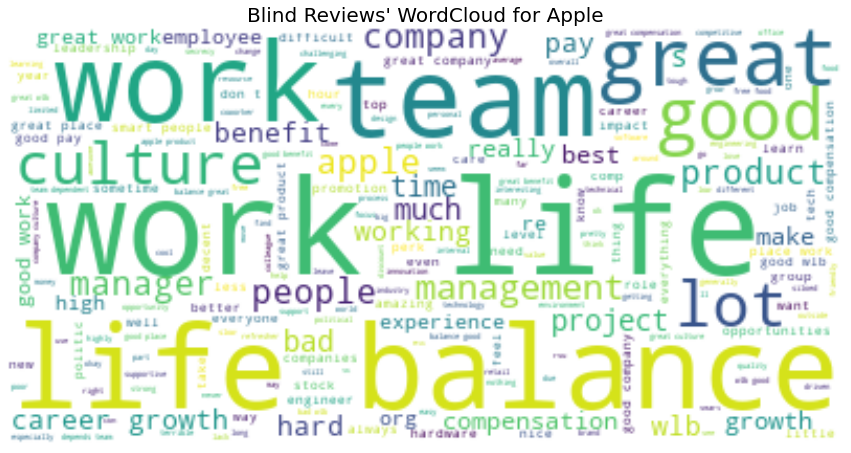

In [15]:
#Getting all visualization about the input company
inp_company_name = input("\nEnter Company Name: ")
company_df, company_analysis_df, company_cloud_image = get_blind_analysis(inp_company_name)

company_df.show()
company_analysis_df.show()

###Data Analysis for Combined Dataset

In [16]:
#Current data for Blind taken from 'Team Blind Review dataset': https://github.com/HarshCasper/Blind-App-Reviews

#Calling blind_data function to load all the data into a spark dataframe
blind_data_df = blind_data('Blind Data')

File 1 (netflix-data.csv) contains 288 reviews
File 2 (ibm-data.csv) contains 1258 reviews
File 3 (adobe-data.csv) contains 954 reviews
File 4 (deloitte-data.csv) contains 1047 reviews
File 5 (amazon-data.csv) contains 9903 reviews
File 6 (sap-labs-data.csv) contains 822 reviews
File 7 (uber-data.csv) contains 1679 reviews
File 8 (oracle-data.csv) contains 1469 reviews
File 9 (twitter-data.csv) contains 685 reviews
File 10 (google-data.csv) contains 5315 reviews
File 11 (goldman-sachs-data.csv) contains 897 reviews
File 12 (airbnb-data.csv) contains 515 reviews
File 13 (meta-data.csv) contains 1680 reviews
File 14 (microsoft-data.csv) contains 5830 reviews
File 15 (salesforce-data.csv) contains 1732 reviews
File 16 (apple-data.csv) contains 1797 reviews
File 17 (intel-data.csv) contains 1227 reviews
File 18 (atlassian-data.csv) contains 458 reviews
File 19 (walmart-data.csv) contains 1377 reviews
File 20 (cisco-data.csv) contains 1488 reviews

The final data contains 40410 reviews from

In [17]:
#Getting schema of Blind Dataframe
blind_data_df.printSchema()

root
 |-- Review No: long (nullable = false)
 |-- Company Name: string (nullable = false)
 |-- Review: string (nullable = true)



In [18]:
#Viewing Blind Dataframe
blind_data_df.show()

+---------+------------+--------------------+
|Review No|Company Name|              Review|
+---------+------------+--------------------+
|        1|     Netflix|Meh. Great comp a...|
|        2|     Netflix|Company for adult...|
|        3|     Netflix|Going down on all...|
|        4|     Netflix|Poor middle manag...|
|        5|     Netflix|Best company I’ve...|
|        6|     Netflix|Changing culture....|
|        7|     Netflix|Top of market all...|
|        8|     Netflix|Changing Landscap...|
|        9|     Netflix|Great work life b...|
|       10|     Netflix|Unmatched salary ...|
|       11|     Netflix|.. Wonderful, int...|
|       12|     Netflix| Opportunities ar...|
|       13|     Netflix|Many changes in t...|
|       14|     Netflix|Good base compens...|
|       15|     Netflix| Great coworkers,...|
|       16|     Netflix|Comp & Culture! T...|
|       17|     Netflix| Top of market co...|
|       18|     Netflix| Great comp and W...|
|       19|     Netflix| Good work

In [19]:
#Getting the sentiment from reviews
blind_data_final = blind_data_df.select('*', udf_sentiment_score(col('Review')).alias('Review Sentiment'))
blind_data_final.show()

+---------+------------+--------------------+----------------+
|Review No|Company Name|              Review|Review Sentiment|
+---------+------------+--------------------+----------------+
|        1|     Netflix|Meh. Great comp a...|        Positive|
|        2|     Netflix|Company for adult...|        Positive|
|        3|     Netflix|Going down on all...|        Positive|
|        4|     Netflix|Poor middle manag...|        Positive|
|        5|     Netflix|Best company I’ve...|        Positive|
|        6|     Netflix|Changing culture....|         Neutral|
|        7|     Netflix|Top of market all...|        Positive|
|        8|     Netflix|Changing Landscap...|         Neutral|
|        9|     Netflix|Great work life b...|        Positive|
|       10|     Netflix|Unmatched salary ...|        Negative|
|       11|     Netflix|.. Wonderful, int...|        Positive|
|       12|     Netflix| Opportunities ar...|        Positive|
|       13|     Netflix|Many changes in t...|        Ne

In [20]:
blind_data_analysis = company_review_analysis(blind_data_final)
blind_data_analysis.show()

+----------------+-----------------+
|Review Sentiment|Number of Reviews|
+----------------+-----------------+
|        Positive|            32966|
|         Neutral|             3412|
|        Negative|             4032|
+----------------+-----------------+



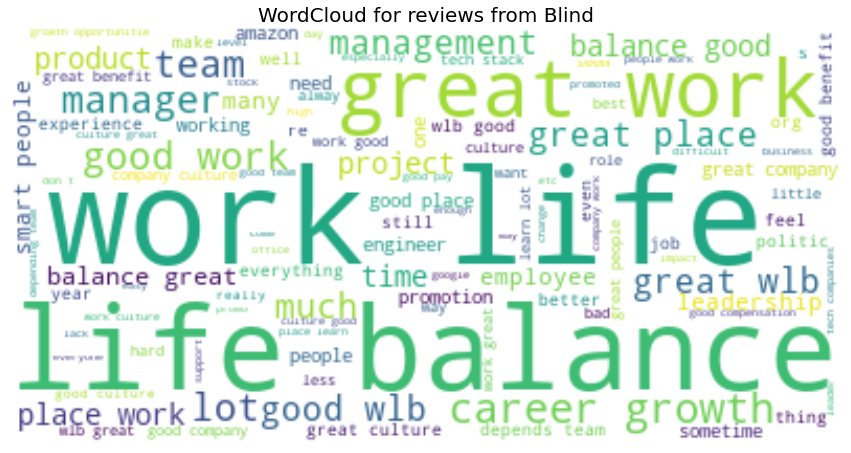

In [21]:
#Getting the WordCloud from Blind data
review_cloud = get_wordcloud(blind_data_df)

#Plotting the WordCloud
plt.figure(figsize=(15,10))
plt.imshow(review_cloud, interpolation='bilinear')
plt.title('WordCloud for reviews from Blind',fontsize=20)
plt.axis("off")
plt.show()